In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
def correct(ereco, A, B):
    return A + (B*np.log(ereco))


In [3]:
lowerRange = 20
upperRange = 80
generator = "Pythia6"
scale = "Pythia6"
with open('{}Reco_R_0.5_dR_0.25.pickle'.format(generator), 'rb') as handle:
    reco_dict_test = pickle.load(handle)
with open('{}Gen_R_0.5_dR_0.25.pickle'.format(generator), 'rb') as handle:
    gen_dict_test = pickle.load(handle)
with open('Scale_{}.pickle'.format(scale), 'rb') as f:
    A, B = pickle.load(f)

In [4]:
mask = (ak.flatten(reco_dict_test["matched_index_new"]) > -1)
matchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
matchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
matchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) > -1
matchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
matchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
matchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

mask = ak.flatten(reco_dict_test["matched_index_new"]) == -1
unmatchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
unmatchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
unmatchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) == -1
unmatchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
unmatchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
unmatchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

In [5]:
PairedGenEtest = matchedGjetEtest
PairedRecoEtest = matchedJetEtest
JetRtest = PairedRecoEtest/PairedGenEtest

In [6]:
correctedReco = np.array(PairedRecoEtest) / correct(PairedRecoEtest, A, B)

JetRC = correctedReco/PairedGenEtest

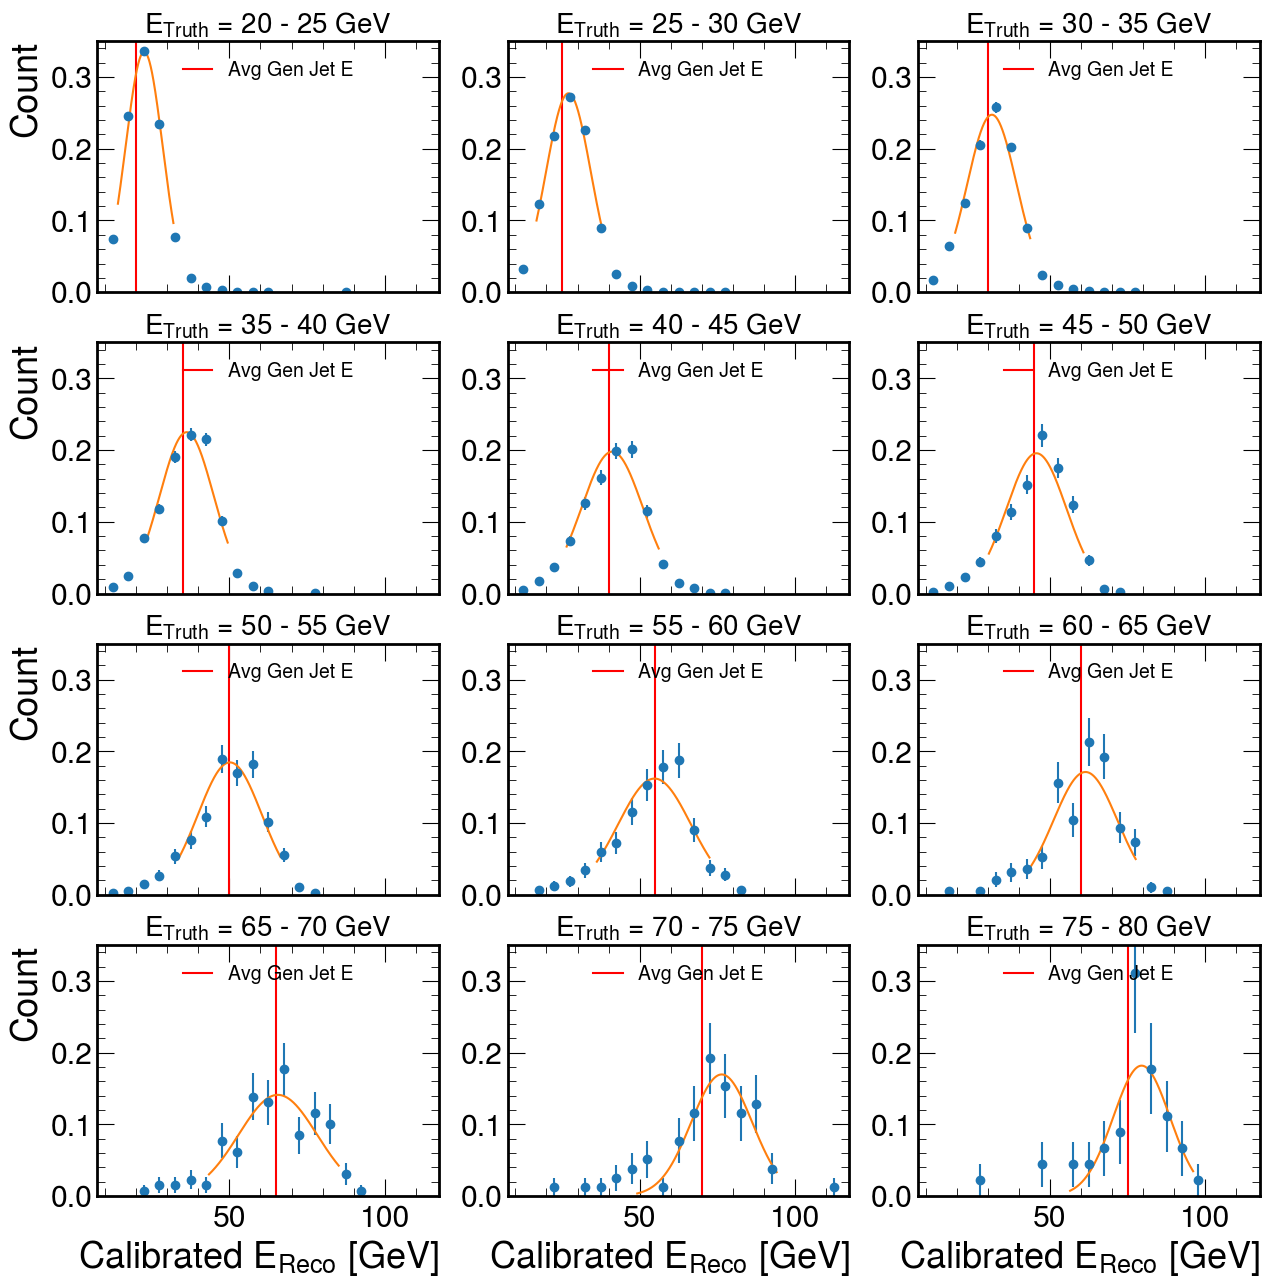

In [14]:
fig, axs=plt.subplots(4, 3, figsize=(15,15),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


CAvgEReco = []
CAvgERecoErr = []

CNumEReco = []
CNumERecoErr = []

GenSlice = []

EBin = 0
for i in range(lowerRange,upperRange,5):
 
    x = (EBin) // 3  
    y = (EBin) % 3
    EBin += 1
    plt.sca(axs[x][y])
        
    genEBin = (PairedGenEtest > i) & (PairedGenEtest < i+(5))
    
    hist, bin_edges = np.histogram(correctedReco[genEBin],bins=40,range=(0,200))
    
    
    zerocut = (hist > 0)
    total = np.sum(hist[zerocut])
    errs = np.sqrt(hist[zerocut]) / total
    hist = hist[zerocut] / total
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    bins = bin_centres[zerocut]
    
    minFit = bins[np.argmax(hist)] - 20
    maxFit = bins[np.argmax(hist)] + 20
    
    minFit = np.mean(correctedReco[genEBin]) - 1.5 * np.std(correctedReco[genEBin])
    maxFit = np.mean(correctedReco[genEBin]) + 1.5 * np.std(correctedReco[genEBin])

    fitCut = (bins > minFit) & (bins < maxFit)
    plt.errorbar(np.array(bins),np.array(hist),yerr=errs,fmt="o")
    
    plt.axvline(i,color='red', label="Avg Gen Jet E")

    
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist),list(errs),gauss)
    m = Minuit(least_squares, A=max(hist), mu = i, sigma = np.std(correctedReco[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,120,5000), m.values[0],m.values[1],m.values[2])
    
    fitPlotCut = (np.linspace(0,150,5000) > minFit) & (np.linspace(0,150,5000) < maxFit)
    hist_fit = gauss(np.linspace(0,150,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,150,5000)[fitPlotCut], hist_fit)
    
    plt.legend(loc='upper center',fontsize=14)
    CNumEReco.append(np.mean(correctedReco[genEBin]))
    CNumERecoErr.append(np.std(correctedReco[genEBin]))
    if not math.isnan(m.values[1]):
        CAvgEReco.append(m.values[1])
        CAvgERecoErr.append(m.errors[1])
    else:
        CAvgEReco.append(0)
        CAvgERecoErr.append(0)

    plt.ylim(0,0.35)
    if(y == 0):
        plt.ylabel("Count")
    if(x == 3):
        plt.xlabel(r"Calibrated $E_{Reco}$ [GeV]")
    plt.title(r'$E_{Truth}$ = %2.0f - %2.0f GeV'%(i, i+5),fontsize=20)

#print(CAvgEReco)
#print(CAvgERecoErr)

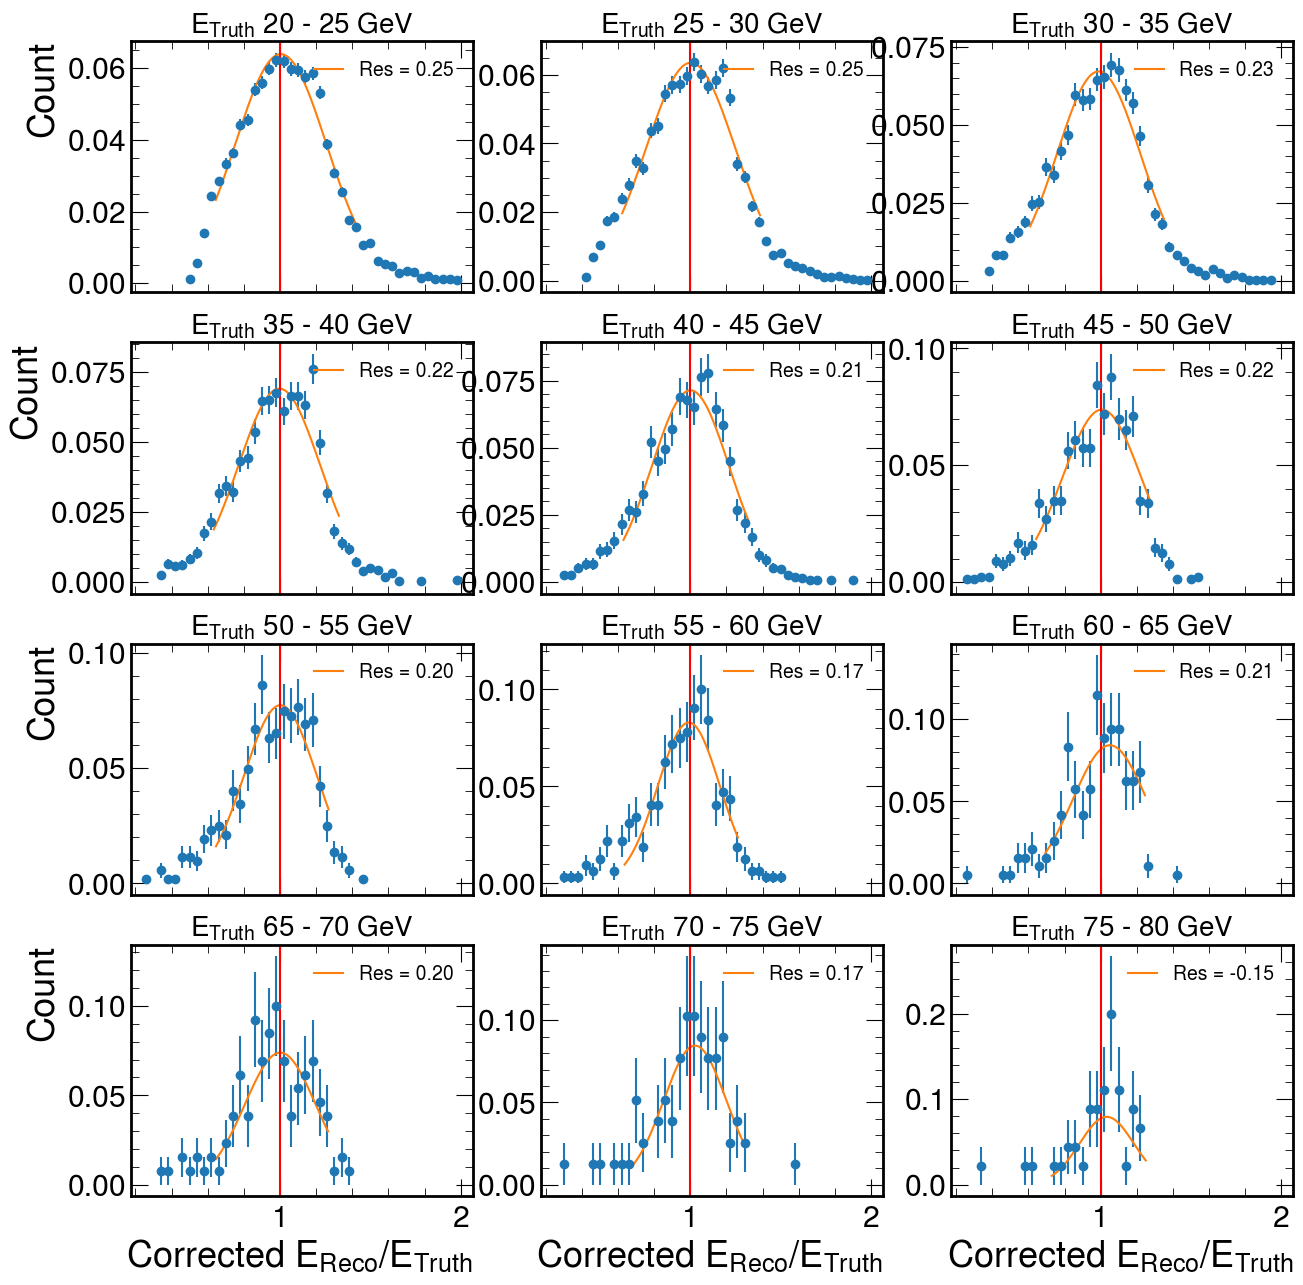

In [15]:
fig, axs=plt.subplots(4, 3, figsize=(15,15),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
 
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

CAvgR = []
CAvgRErr = []

CNumR = []
CNumRErr = []

Res = []
ResErr = []

Sigma = []
SigmaErr = []

GenSlice = []
EBin = 0
for i in range(lowerRange,upperRange,5):
 
    x = (EBin) // 3  
    y = (EBin) % 3
    EBin += 1
    plt.sca(axs[x][y])
        
    genEBin = (PairedGenEtest > i) & (PairedGenEtest < i+(5))
    
    hist, bin_edges = np.histogram(JetRC[genEBin],bins=50,range=(0,2))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
    zerocut = (hist > 0)
    errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
    hist = hist[zerocut] / np.sum(hist[zerocut])
    bins = bin_centres[zerocut]
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o")

    minFit = bins[np.argmax(hist)] - 0.5
    maxFit = bins[np.argmax(hist)] + 0.5
    minFit = np.mean(JetRC[genEBin]) - 1.5 * np.std(JetRC[genEBin])
    maxFit = np.mean(JetRC[genEBin]) + 1.5 * np.std(JetRC[genEBin])
 
    fitCut = (bins > minFit) & (bins < maxFit)
    
       
    least_squares = LeastSquares(list(bin_centres[zerocut][fitCut]),list(hist[fitCut]),list(errs[fitCut]),gauss)
    m = Minuit(least_squares, A=max(hist), mu = 1.0, sigma = np.std(JetRC[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,2,5000), m.values[0],m.values[1],m.values[2])
    fitPlotCut = (np.linspace(0,2,5000) > minFit) & (np.linspace(0,2,5000) < maxFit)
    hist_fit = gauss(np.linspace(0,2,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
    
    plt.plot(np.linspace(0,2,5000)[fitPlotCut], hist_fit, label = "Res = %2.2f"%m.values[2])
    CNumR.append(np.mean(JetRC[genEBin]))
    CNumRErr.append(np.std(JetRC[genEBin]))
    plt.axvline(1,color='red')
    if (not math.isnan(m.values[1])):
        CAvgR.append(m.values[1])
        Res.append(np.abs(m.values[2])/m.values[1])

        ResErr.append(np.abs(m.errors[2])/ m.values[1])

        Sigma.append(np.abs(m.values[2]))

        SigmaErr.append(np.abs(m.errors[2]))

        CAvgRErr.append(m.errors[1])
    else:
        CAvgR.append(0)
        CAvgRErr.append(0)
    #plt.ylim(0,0.21)
    plt.legend(loc='upper right',fontsize=14)
    if(y == 0):
        plt.ylabel("Count")
    if(x == 3):
        plt.xlabel(r"Corrected $E_{Reco}$/$E_{Truth}$")
    plt.title(r'$E_{Truth}$ %2.0f - %2.0f GeV'%(i, i+(5)),fontsize=20)


#print(CAvgR)
#print(CAvgRErr)

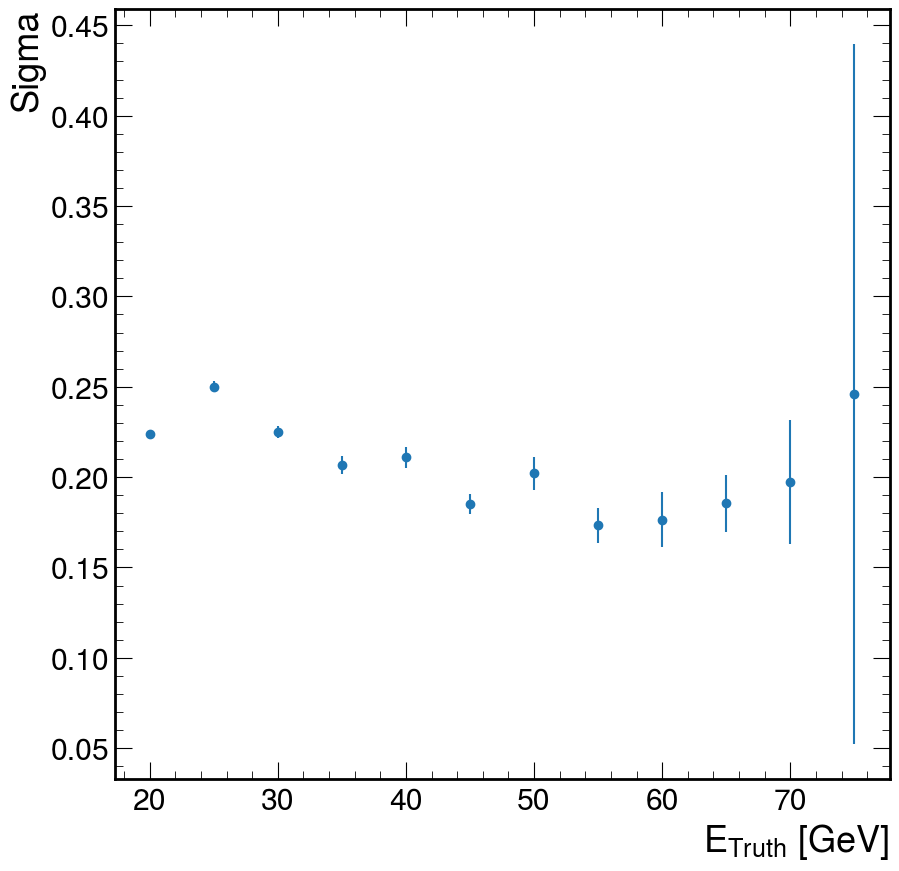

In [9]:
bin_centres = range(lowerRange,upperRange,5)

plt.errorbar(bin_centres,Sigma,yerr=SigmaErr,fmt="o")

plt.xlabel(r'$E_{Truth}$ [GeV]')
plt.ylabel('Sigma')

#plt.ylim(0,0.3)
with open('Sigma_{}_C{}.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres), Res, ResErr), f)

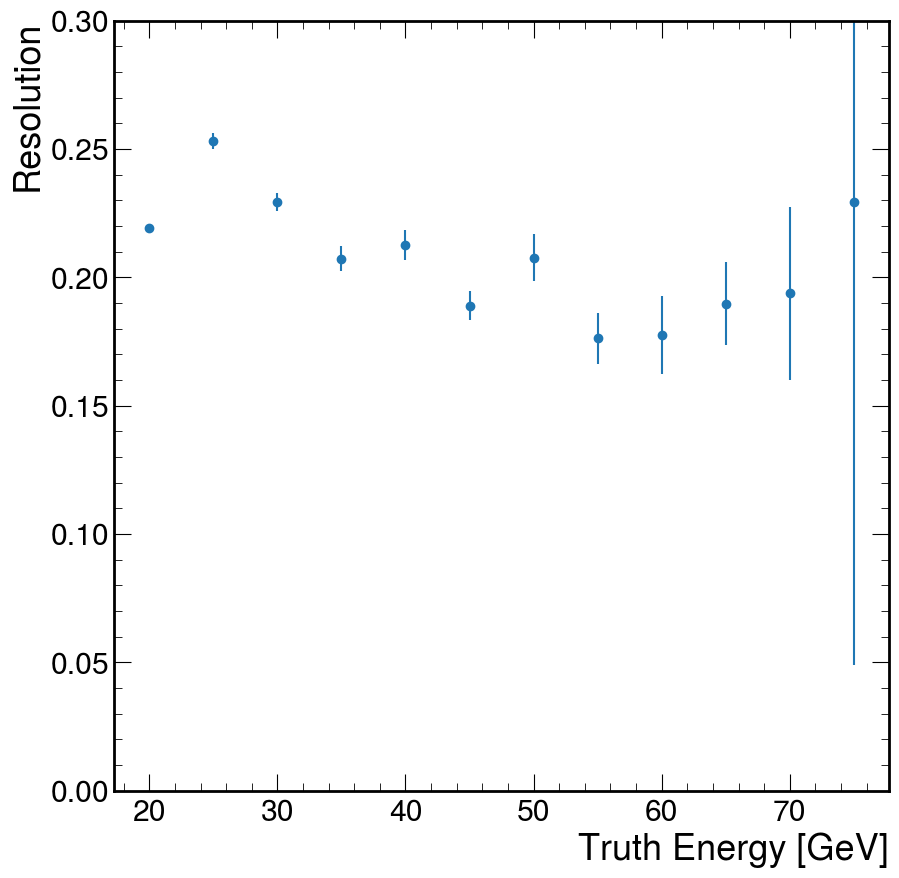

In [10]:
bin_centres = range(lowerRange,upperRange,5)

plt.errorbar(np.array(bin_centres),Res,yerr=ResErr,fmt="o")

plt.xlabel('Truth Energy [GeV]')
plt.ylabel('Resolution')
plt.ylim(0,0.3)
with open('Res_{}_C{}.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres), Res, ResErr), f)

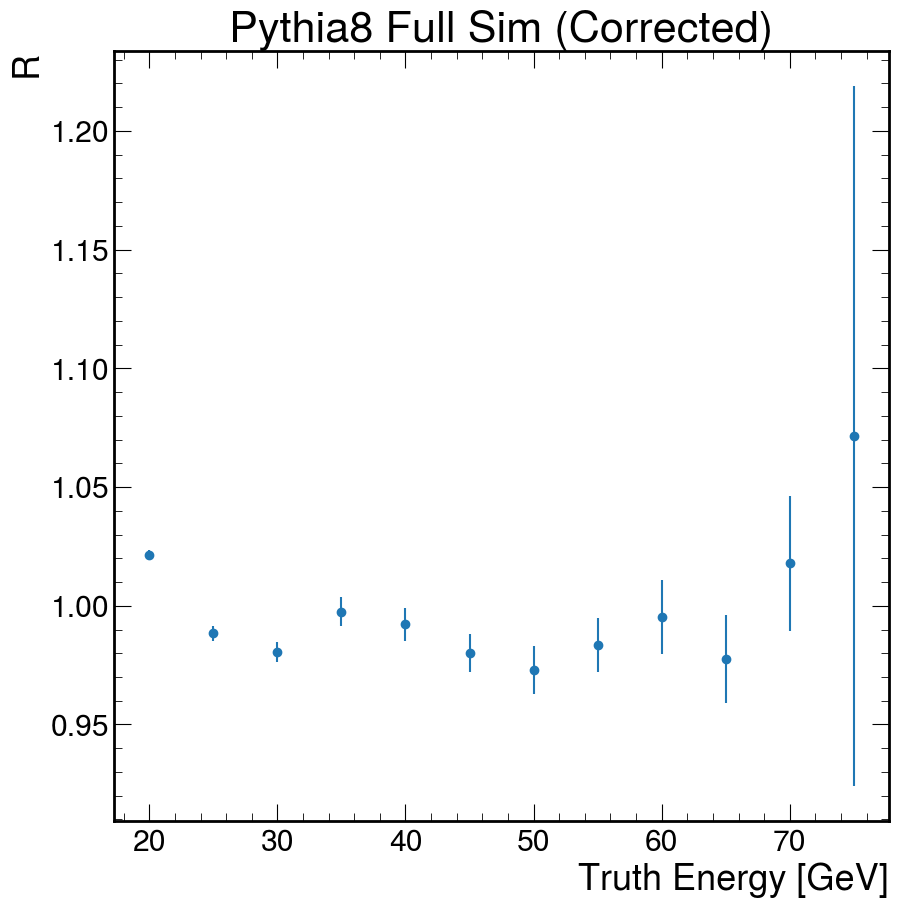

In [11]:


plt.errorbar(np.array(bin_centres),CAvgR,yerr=CAvgRErr,fmt="o")

plt.xlabel('Truth Energy [GeV]')
plt.ylabel('R')
plt.title("Pythia8 Full Sim (Corrected)")
#plt.ylim(0.9,1.0)
with open('R_{}_C{}.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres), CAvgR, CAvgRErr), f)

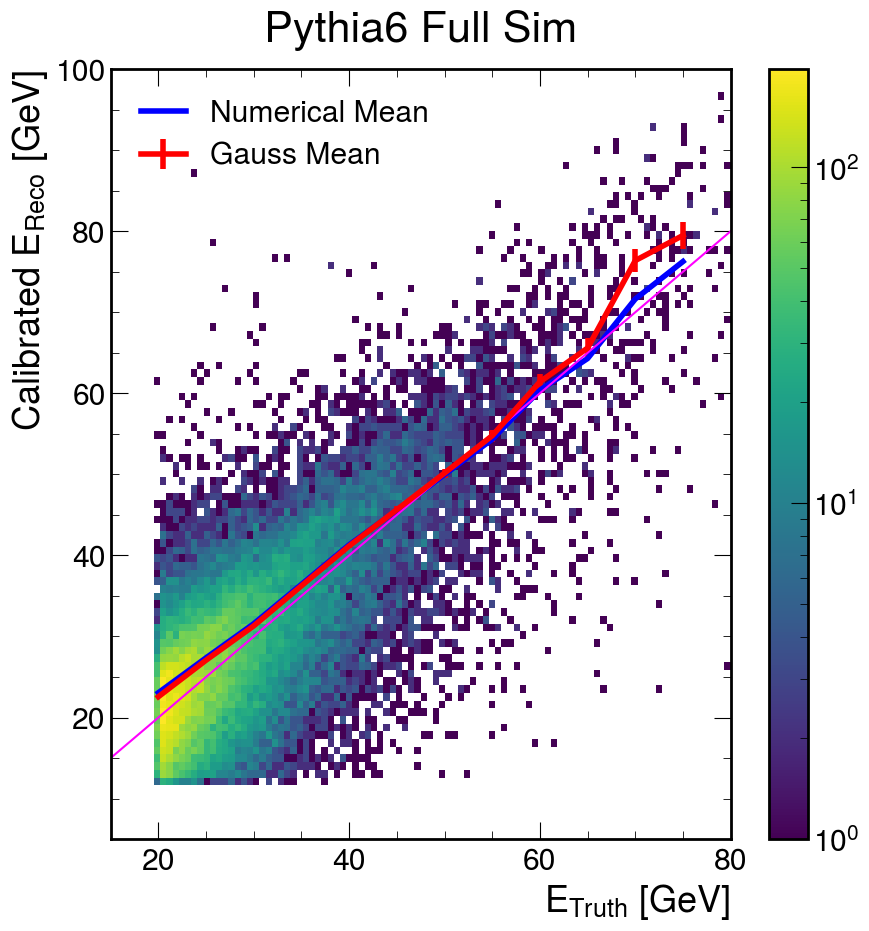

In [12]:
plt.hist2d(np.array(PairedGenEtest),np.array(correctedReco),bins=(100,100),range=([15,80],[5,100]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.errorbar(bin_centres, CAvgEReco, yerr=CAvgERecoErr,color='red',label="Gauss Mean",linewidth=4)
plt.plot(bin_centres, CNumEReco, color='blue',label="Numerical Mean",linewidth=4)
plt.plot(np.linspace(0,200,1000),np.linspace(0,200,1000),color='magenta')
plt.legend(loc="upper left")
#print(CNumEReco) 
plt.xlabel(r'$E_{Truth}$ [GeV]') 
plt.ylabel(r'Calibrated $E_{Reco}$ [GeV]')
plt.title("{} Full Sim".format(generator),pad = 20.0)
plt.show()

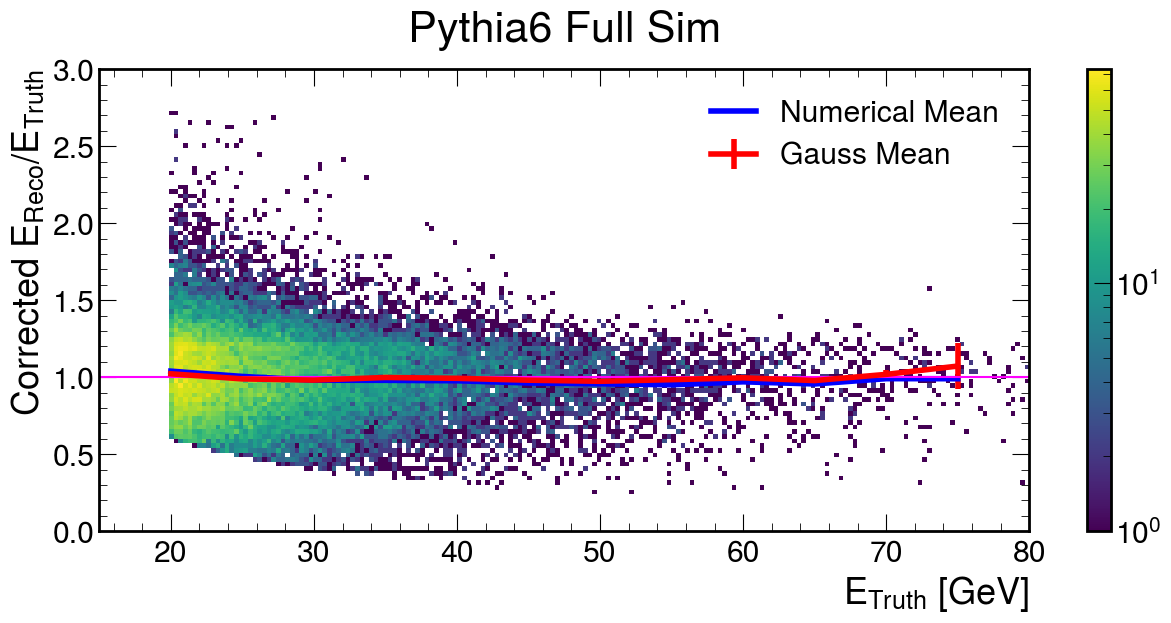

In [13]:
fig = plt.figure(figsize=(15,6))



plt.hist2d(np.array(PairedGenEtest),np.array(JetRC),bins=(200,100),range=([15,80],[0,3]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()

plt.errorbar(bin_centres, CAvgR, yerr=CAvgRErr,color='red',label="Gauss Mean",linewidth=4)
plt.plot(bin_centres, CNumR, color='blue',label="Numerical Mean",linewidth=4)
plt.plot(np.linspace(0,200,1000),np.ones(1000),color='magenta')
plt.legend(loc="upper right")
plt.xlabel(r'$E_{Truth}$ [GeV]')
plt.ylabel(r'Corrected $E_{Reco}$/$E_{Truth}$')
plt.title("{} Full Sim".format(generator),pad = 20.0)
plt.show()